In [2]:
import numpy as np
import pandas as pd
import seaborn as sns  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Supervised Contrastive (SimCLR) loss vs Cross Entropy (Normal): 

### initial experiment

In [3]:
clf_val  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_finetuning_checkpoint_300__2021_02_05_14_25_loss.csv')
norm_val = pd.read_csv('./record/Encoder_64-128-256-512-128-7_mode_normal_on_exp4csi_finetuning_checkpoint_300__2021_02_04_17_42_loss.csv')
clf_acc  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_finetuning_checkpoint_300__2021_02_05_14_25_accuracy.csv')
norm_acc = pd.read_csv('./record/Encoder_64-128-256-512-128-7_mode_normal_on_exp4csi_finetuning_checkpoint_300__2021_02_04_17_42_accuracy.csv')
clf_pre = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_pretrain_checkpoint_500__2021_02_05_14_19_loss.csv')
clf_cmtx  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_finetuning_checkpoint_300__2021_02_05_14_25_cmtx.csv',index_col=0)
norm_cmtx = pd.read_csv('./record/Encoder_64-128-256-512-128-7_mode_normal_on_exp4csi_finetuning_checkpoint_300__2021_02_04_17_42_cmtx.csv',index_col=0)

For dataset, we use 80% of the dataset as training set, it consist of 6 activities: walking, sitting, standing (from chair), laying down and picking up (we exclude 'standing from floor' to reduce possible confusion in this stage)

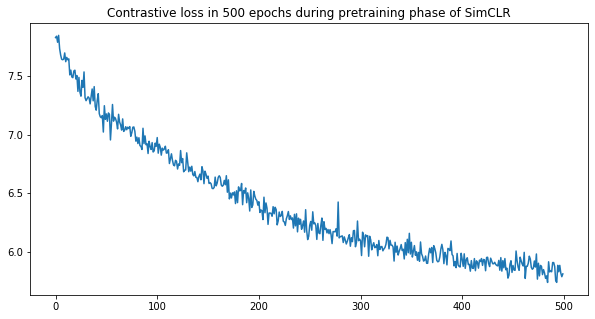

In [4]:
clf_pre['train_loss'].plot(figsize=(10,5),title='Contrastive loss in 500 epochs during pretraining phase of SimCLR')

In contrastive training, the distance (cosine distance/euclidean distance) between the two vectors from two labels are pulling away from each other, and essentially, the contrastive training is a cluster process. With different clusters, we need to build a classifier to perform the classification. In SimCLR, it does so by replacing the projection head with a classifier. Thus,  training a classifier is always necessary.   
The model, consisted of four layers encoder and linear projection head (128,) is trained with 500 epochs and SGD with learning rate of $10^{-5}$ for pretraining as previously suggested, the loss is with the decrease trend and fluctuated due to the stochastic nature of SGD

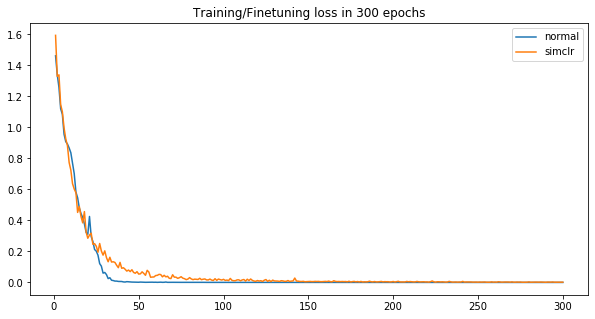

In [5]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,301),norm_val['train_loss'].values)
plt.plot(np.arange(1,301),clf_val['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 300 epochs')
plt.show()

After pretraining, we discard the projection head, freeze the encoder, and build a mlp (128--6) on top of it. And finetune with cross entropy, with 300 epochs and ADAM with learning rate of $10^{-5}$. To compare, we train a normal model for comparision with the same architecutre and setting (except freezing the encoder) 
Above shows the training loss in normal setting decrease much faster than in pretrained setting. 

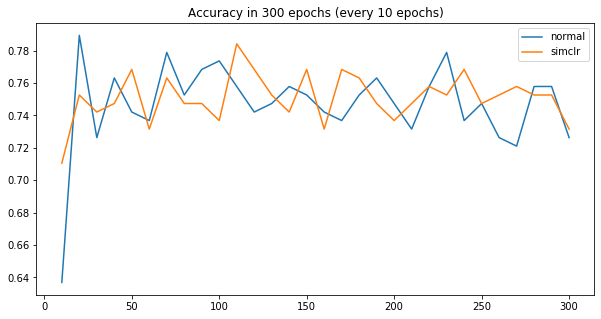

In [6]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,310,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,310,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

For the actually accuracy. In general, they reach a similar level of 72-76%. With the pretraining, the model reach above 70% in first 10 epochs, significantly better than the normal. After that, they perform similarily. 

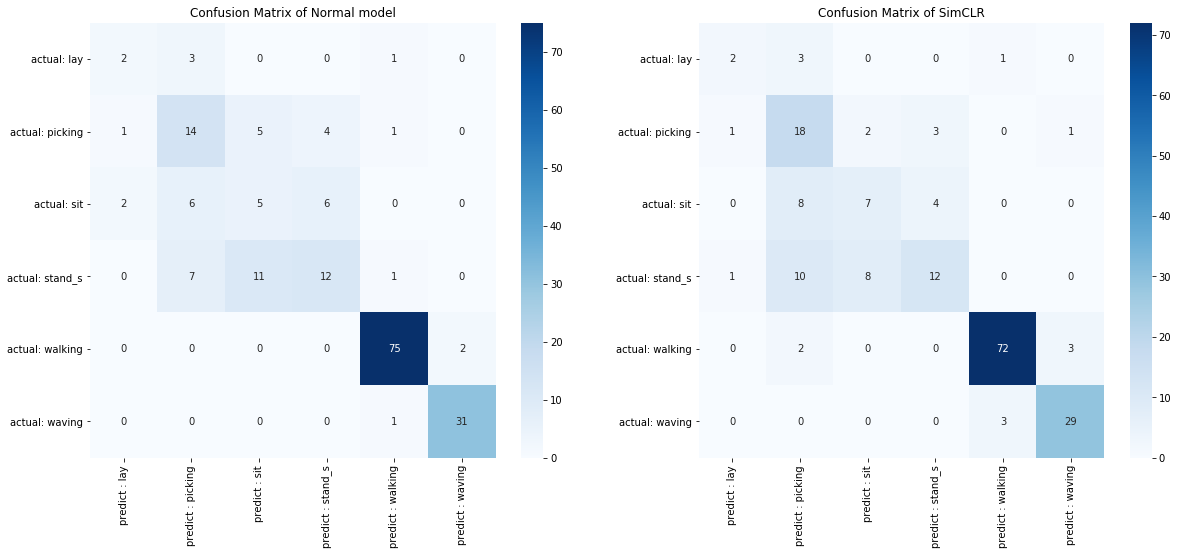

In [7]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True)
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True)
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

Here are the confusion matrix

### pretrained with 4000 epoch, classes applied by oversampled train set and undersampled test set

In [2]:
clf_pre = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_pretrain_checkpoint_4000__2021_02_08_22_43_loss.csv')
clf_loss  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_finetuning_checkpoint_200__2021_02_08_22_51_loss.csv')
clf_acc  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_finetuning_checkpoint_200__2021_02_08_22_51_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/Encoder_64-128-256-512-64-7_mode_clf_on_exp4csi_s_resampled_4000epochs_finetuning_checkpoint_200__2021_02_08_22_51_cmtx.csv',index_col=0)

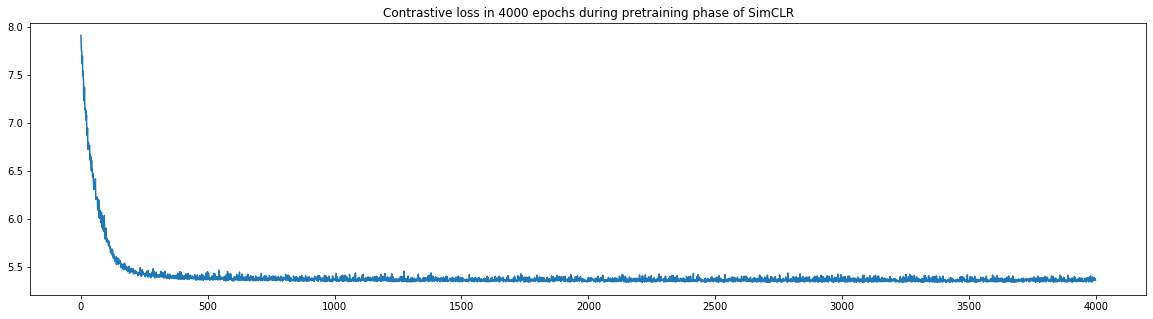

In [4]:
clf_pre['train_loss'].plot(figsize=(20,5),title='Contrastive loss in 4000 epochs during pretraining phase of SimCLR')

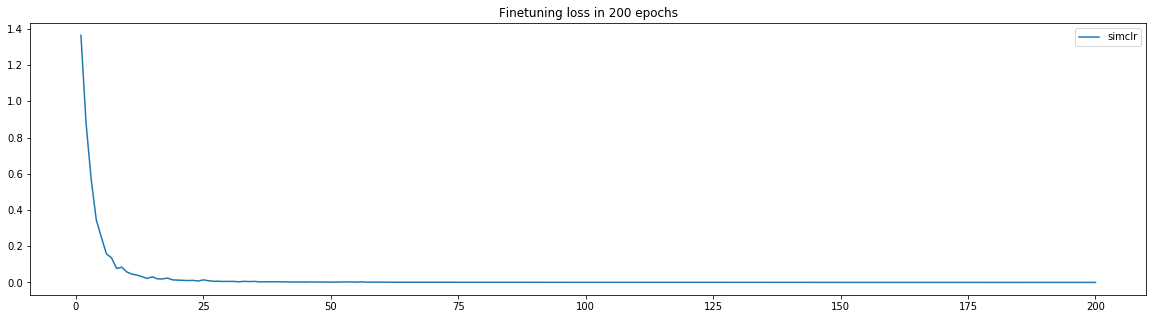

In [7]:
plt.figure(figsize=(20,5))
plt.plot(np.arange(1,201),clf_loss['train_loss'].values)
plt.legend(['simclr'])
plt.title('Finetuning loss in 200 epochs')
plt.show()

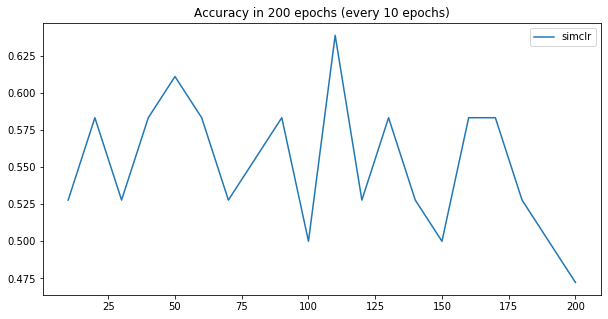

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values)
plt.legend(['simclr'])
plt.title('Accuracy in 200 epochs (every 10 epochs)')
plt.show()

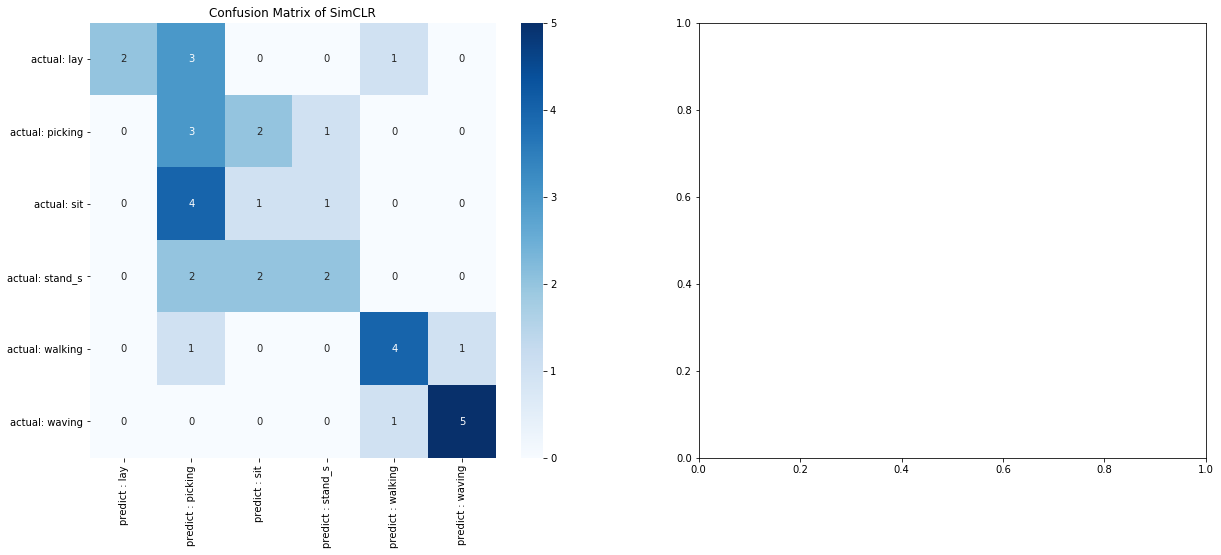

In [9]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(clf_cmtx,ax=axs[0],cmap='Blues',annot=True)
axs[0].set_title('Confusion Matrix of SimCLR')
plt.show()

# 2. self-supervised contrastive learning: single modality (2 NUC)  

In data collection, we use two receivers to collect CSI from single transmitter. Utilise this nature, we perfrom an self-supervised contrastive learning, where we group the two spectrogram that collected simultanously as positive pair while making the others as negative pair.  

**Setup**

* Encoder: VGG-16
* Dataset: All 6 activities except "standing from the ground", undergoes normalization(axis 0). All sepctrograms used for pretraining. $p$ of all the spectrograms are used for fintuning and remained are used for validation.
* batch size: 64
* Epochs: 600 (pretrain), 200 (finetuning/training) 
* optimizer: SGD (pretraining), ADAM (finetuning/training)
* loss: NT-Xent (pretraining), Cross-entropy (finetuning/training)


### $p$ = 1

In [4]:
clf_pre = pd.read_csv('./record/'+'Encoder_vgg16_mode_clf_on_exp4csipair_pretrain_checkpoint_800__2021_02_11_23_40_loss.csv')

In [5]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_finetuning_checkpoint_200__2021_02_11_23_47'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)

In [3]:
norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_finetuning_checkpoint_200__2021_02_12_16_02'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

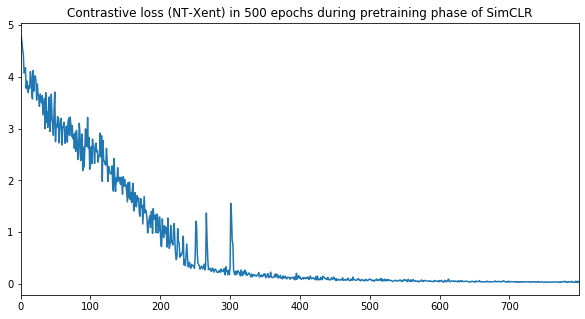

In [6]:
clf_pre['train_loss'].plot(figsize=(10,5),title='Contrastive loss (NT-Xent) in 500 epochs during pretraining phase of SimCLR')

We can see the loss between 0 to 200 epochs shows a constant decreasing trend. Experiencing a spike of increase between 200 to 300 epochs, the loss converges approximately at  400 epochs

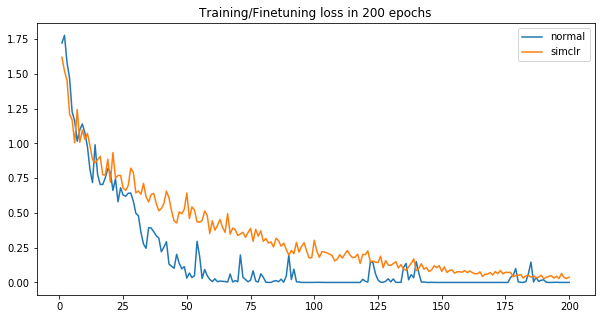

In [7]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,201),norm_loss['train_loss'].values)
plt.plot(np.arange(1,201),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 200 epochs')
plt.show()

Comparing between the normal training and finetuning(simclr), the former converge at 75 epochs, significantly faster than the latter, it also experience more unstable spikes afterward.  

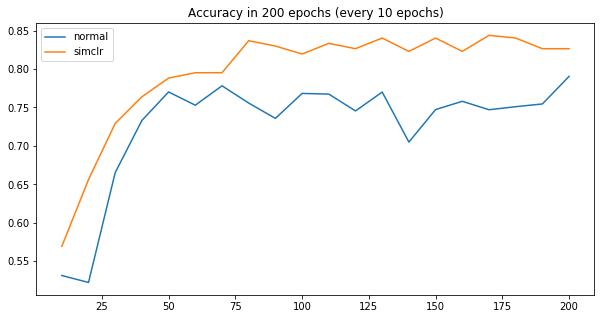

In [8]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,210,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 200 epochs (every 10 epochs)')
plt.show()

Unlike the loss, the model train after simclr is significantly better than the normal model during the entire fine-tuning/training.  

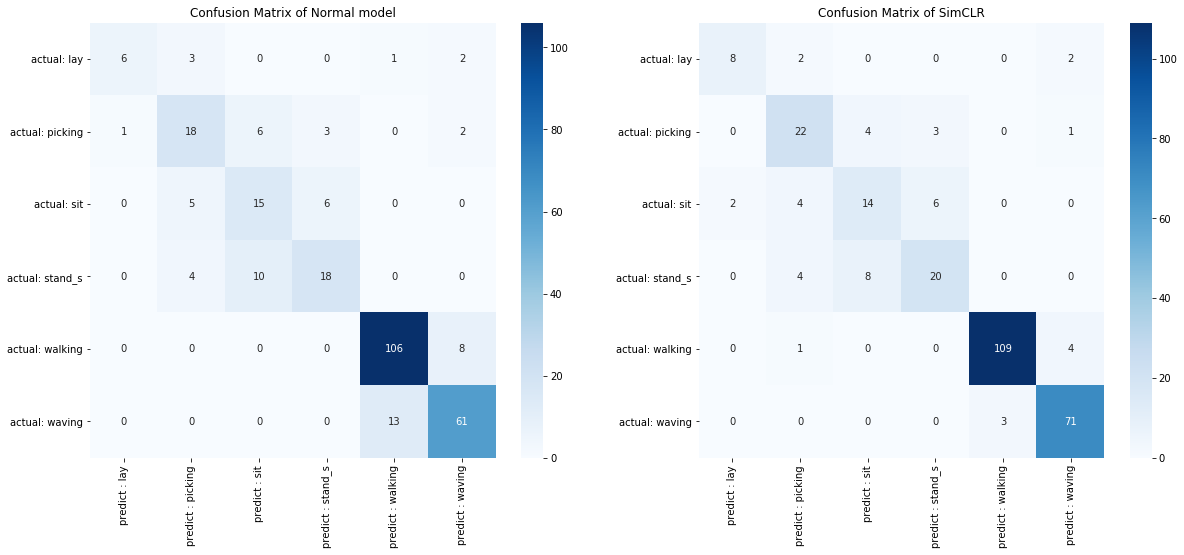

In [9]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

### $p$ = 0.25

In [19]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_s_p025_finetuning_checkpoint_200__2021_02_12_16_24'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)
norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_s_p025_finetuning_checkpoint_200__2021_02_12_16_34'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

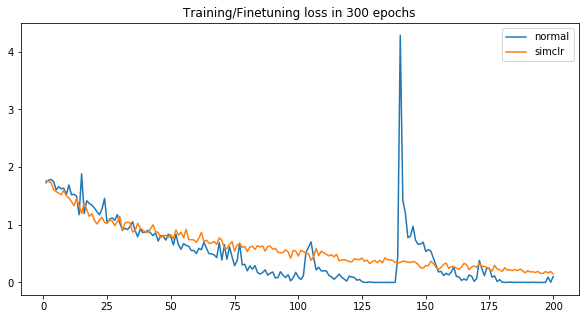

In [20]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,201),norm_loss['train_loss'].values)
plt.plot(np.arange(1,201),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 300 epochs')
plt.show()

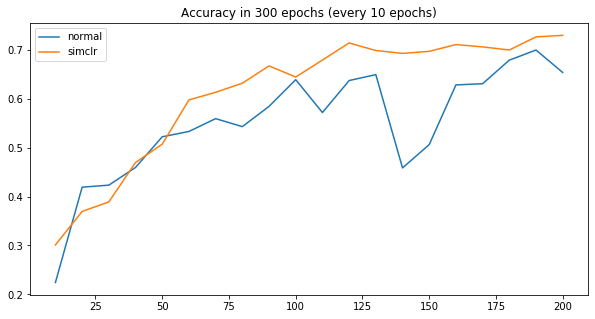

In [21]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,210,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,210,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

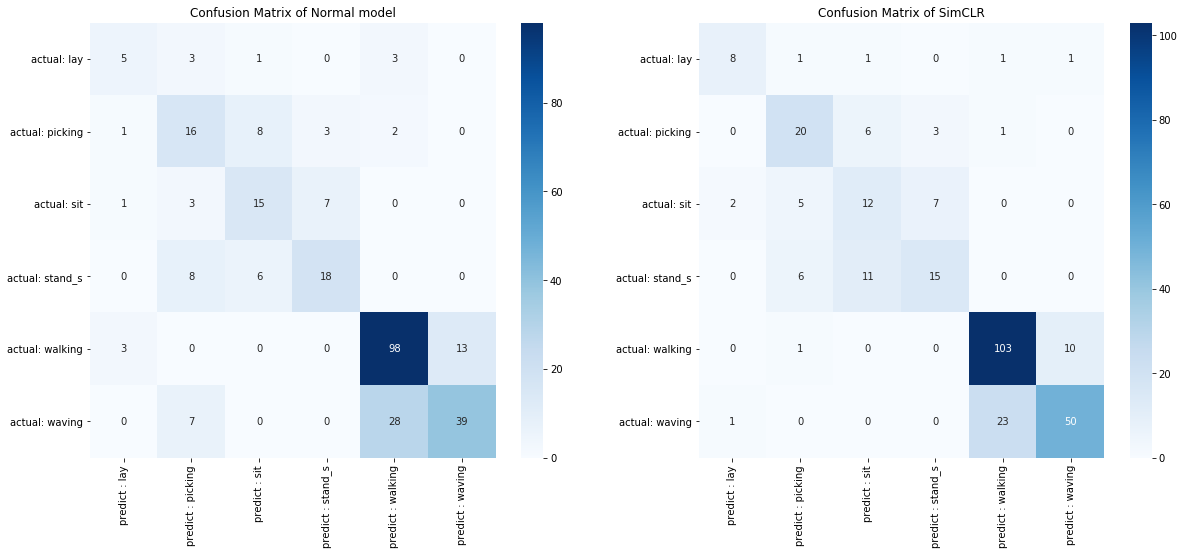

In [22]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()

### $p$ = 0.1

In [23]:
clf_expname = 'Encoder_vgg16_mode_clf_on_exp4csipair_s_p010_finetuning_checkpoint_300__2021_02_12_16_47'
clf_loss  = pd.read_csv('./record/'+clf_expname+'_loss.csv')
clf_acc  = pd.read_csv('./record/'+clf_expname+'_accuracy.csv')
clf_cmtx  = pd.read_csv('./record/'+clf_expname+'_cmtx.csv',index_col=0)
norm_expname = 'Encoder_vgg16_mode_normal_on_exp4csipair_s_p010_finetuning_checkpoint_300__2021_02_12_17_00'
norm_loss  = pd.read_csv('./record/'+norm_expname+'_loss.csv')
norm_acc  = pd.read_csv('./record/'+norm_expname+'_accuracy.csv')
norm_cmtx  = pd.read_csv('./record/'+norm_expname+'_cmtx.csv',index_col=0)

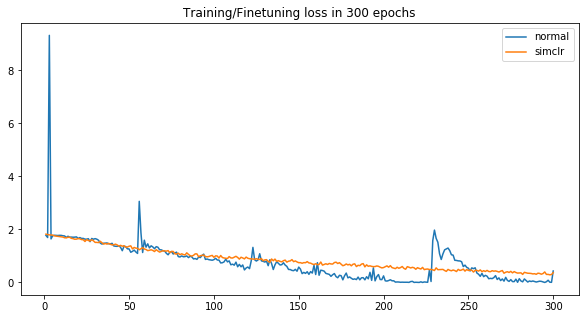

In [24]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1,301),norm_loss['train_loss'].values)
plt.plot(np.arange(1,301),clf_loss['train_loss'].values)
plt.legend(['normal','simclr'])
plt.title('Training/Finetuning loss in 300 epochs')
plt.show()

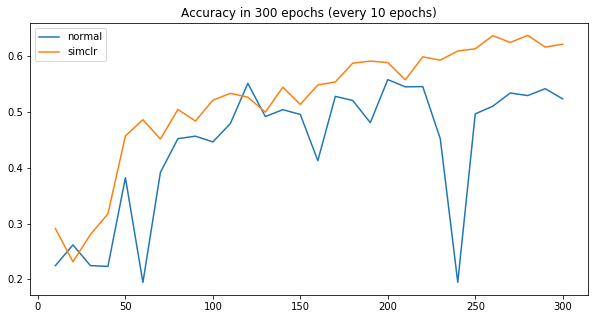

In [25]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(10,310,10),norm_acc['validation_accuracy'].values)
plt.plot(np.arange(10,310,10),clf_acc['validation_accuracy'].values)
plt.legend(['normal','simclr'])
plt.title('Accuracy in 300 epochs (every 10 epochs)')
plt.show()

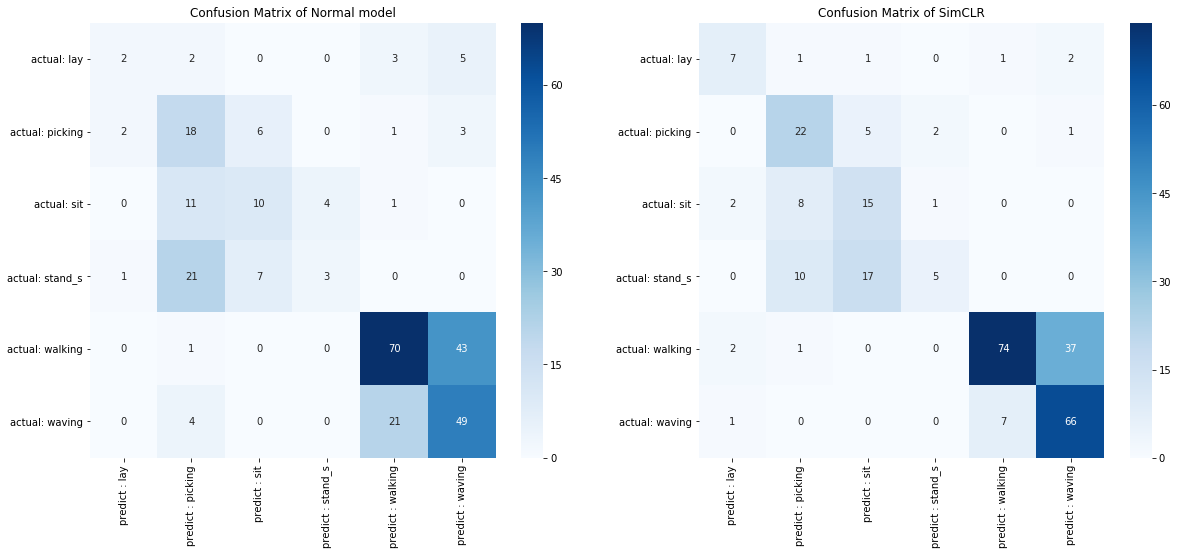

In [26]:
f,axs = plt.subplots(1,2,figsize=(20,8))
sns.heatmap(norm_cmtx,ax=axs[0],cmap='Blues',annot=True, fmt='g')
axs[0].set_title('Confusion Matrix of Normal model')
sns.heatmap(clf_cmtx,ax=axs[1],cmap='Blues',annot=True, fmt='g')
axs[1].set_title('Confusion Matrix of SimCLR')
plt.show()